In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os

import torch

from src.data.names import Names
from src.config import DATA_DIR, ROOT_DIR

# Data

In [3]:
files = [
    filename
    for filename in os.listdir(DATA_DIR)
    if filename.endswith(".txt") and filename.startswith("yob")
]

In [4]:
files.sort()

In [5]:
all_data = {}
for filename in files:
    # print(filename)
    year = int(filename[3:7])
    with open(DATA_DIR / filename) as f:
        for line in f:
            line_data = line.strip().lower().split(",")
            if line_data[1] == "f":
                if line_data[0] in all_data:
                    all_data[line_data[0]] += float(line_data[2]) * (
                        1 + (year - 1880) / 142
                    )
                else:
                    all_data[line_data[0]] = float(line_data[2]) * (
                        1.0 + (year - 1880) / 142
                    )

In [6]:
with open(DATA_DIR / "all_names.txt", "w") as f:
    for name, count in all_data.items():
        f.write(f"{name},{count}\n")

In [7]:
female_names = Names()
female_names.read_file(DATA_DIR / "all_names.txt", counts=True)

In [8]:
female_names.train_test_split(0.8)

In [9]:
sum(female_names.train.values()) / sum(female_names.test.values())

4.016192704928459

Max length:  15
Min length:  2
Avg length:  6.022801094407072


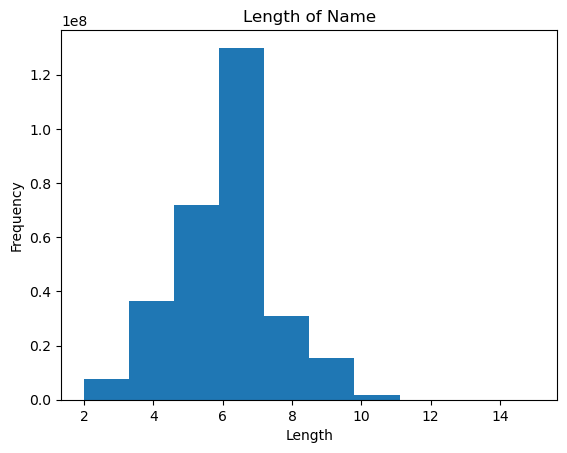

In [10]:
female_names.eda()

# Bigram model

In [11]:
from src.bigram.bigram import BigramModel

In [12]:
model = BigramModel(names=female_names)
model.train()
# model.visualise()

In [13]:
torch.save(model, ROOT_DIR / "models" / "bigram.pt")

# Prediction with bigram model

In [14]:
model = torch.load(ROOT_DIR / "models" / "bigram.pt")

In [15]:
generator = torch.Generator().manual_seed(36)

In [17]:
for _ in range(30):
    print(model.predict(generator=generator))

rimbinelicahanandiziane
arllme
jonellabi
chary
hadra
rl
liae
bethi
chnenen
re
ve
a
ananetha
e
kiststyshautha
mabrodalyst
abelliaren
habrexasta
matatenda
ty
stosiennranerizie
bel
andilinan
leliadilllariratena
mia
ja
na
mbra
cqutauty
dindepamorikelliahnethithananeavawn


# Calculating losses

In [18]:
model.evaluate()

{'baseline_train_loss': tensor(3.2958),
 'baseline_test_loss': tensor(3.2958),
 'model_train_loss': tensor(2.2321),
 'model_test_loss': tensor(2.2627)}

In [24]:
random_bigram_array = model.create_bigram_array({"ruby": 1})
model.loss(random_bigram_array, model.bigram_probs)

tensor(2.6981)

# Bigram Neural Net

In [25]:
from src.nnet.nnet import BigramNnet

In [27]:
bigram_nnet = BigramNnet(names=female_names)
bigram_nnet.get_data()

AttributeError: type object 'BigramModel' has no attribute 'create_bigram_list'

In [97]:
bigram_nnet.forward(bigram_nnet.x_train)

tensor([[0.0063, 0.0079, 0.0034,  ..., 0.0296, 0.0099, 0.0260],
        [0.0247, 0.0691, 0.0036,  ..., 0.0106, 0.0350, 0.0299],
        [0.0176, 0.0147, 0.0333,  ..., 0.0154, 0.0269, 0.0407],
        ...,
        [0.0167, 0.0351, 0.0187,  ..., 0.0482, 0.0318, 0.0446],
        [0.0176, 0.0147, 0.0333,  ..., 0.0154, 0.0269, 0.0407],
        [0.0127, 0.0109, 0.0093,  ..., 0.0238, 0.0248, 0.0436]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
# Single layer, 28 neurons
generator = torch.Generator().manual_seed(36)
n_neurons = 28
layer = torch.randn((28, n_neurons), generator=generator, requires_grad=True)

In [ ]:
# Forward pass
def forward(layer, xenc, y, reg=0.0):
    """Forward pass of a single layer."""
    # Neuron activations
    output = xenc @ layer  # (n_samples x 28) @ (28 x n_neurons) = n_samples x n_neurons
    # Softmax for probs
    probs = torch.softmax(output, dim=1)
    # CCE Loss
    # Extract probabilities for correct characters (i.e. each character in y)
    # for each row (each value in the arange), extract the yth value
    prob_correct = probs[torch.arange(len(y)), y]
    # log the probs and take the negative and mean. Add L2 regularisation
    loss = -1 * torch.log(prob_correct).sum() / len(y) + reg * torch.sum(layer**2)
    return loss


loss = forward(layer, xenc, y)
loss

tensor(3.8369, grad_fn=<DivBackward0>)

In [ ]:
# Training
loss_history = [loss.item()]

In [ ]:
# Backward pass
layer.grad = None
loss.backward()

In [ ]:
# Update weights
layer.data -= 0.1 * layer.grad

In [ ]:
loss2 = forward(layer, xenc, y)
loss_history.append(loss2.item())

In [ ]:
for i in range(10000):
    loss = forward(layer, xenc, y)
    layer.grad = None
    loss.backward()
    layer.data -= 0.1 * layer.grad
    if i % 1000 == 0:
        print(f"Loss at iteration {i}: {loss.item():.2f}")
    loss_history.append(loss.item())

Loss at iteration 0: 2.27
Loss at iteration 1000: 2.27
Loss at iteration 2000: 2.27
Loss at iteration 3000: 2.27
Loss at iteration 4000: 2.26
Loss at iteration 5000: 2.26
Loss at iteration 6000: 2.26
Loss at iteration 7000: 2.26
Loss at iteration 8000: 2.26
Loss at iteration 9000: 2.26


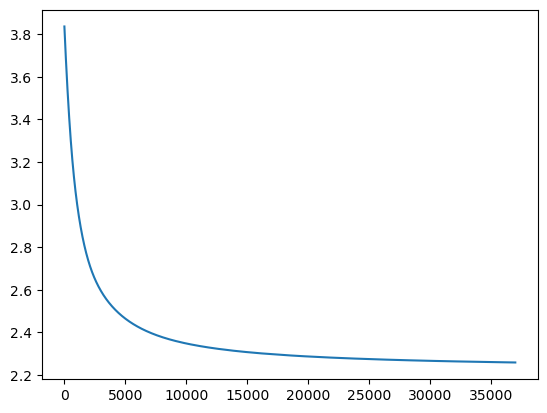

In [ ]:
plt.plot(loss_history)

In [ ]:
torch.exp(layer)[
    0
]  # analogous to bigram_array[0], but trained by gradient descent instead of counted

tensor([ 0.2138,  8.4388,  0.8021,  0.5385,  2.0631,  0.3442,  0.3227,  0.7369,
         1.3815,  0.5675,  1.1072,  2.4110,  0.2927,  2.8797,  2.4770,  0.3865,
         2.7280,  0.2044,  2.9256, 10.4059,  1.0793,  0.6638,  2.3538,  0.2506,
         0.2036,  0.6265,  0.3615,  0.2198], grad_fn=<SelectBackward0>)

In [ ]:
generator = torch.Generator().manual_seed(36)


def predict(xenc, layer=layer, generator=generator):
    """Predicts the next character given a layer and a one-hot encoded character."""
    output = xenc @ layer
    probs = torch.softmax(output, dim=0)
    return torch.multinomial(probs, 1, generator=generator).item()

In [ ]:
# Prediction loop
for i in range(10):
    word = "^"
    start = torch.nn.functional.one_hot(
        torch.tensor(char2int[word[-1]]), num_classes=28
    ).float()
    while True:
        torch.no_grad()
        next_index = predict(start)
        next_char = int2char[next_index]
        if next_char == "^":
            continue
        if next_char == "$":
            break
        start = torch.nn.functional.one_hot(
            torch.tensor(next_index), num_classes=28
        ).float()
        word += next_char
    print(word[1:])

sheeshiyal
dindel
ahishu
su
m
aantasusubhai
niketissuninanit
shithara
givai
t


In [ ]:
# torch.save(layer, "models/layer.pt")

# Bengio embedding-based multi-gram neural net
Based on https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [ ]:
# Length of look-back
block_size = 3
embedding_size = 2
token_size = len(chars)

In [ ]:
list_X, list_Y = [], []
# Create list of all lookback blocks of block_size and their corresponding next character
for name in train_names:
    # Add start and end tokens (block_size of start tokens).
    name_startend = ("^" * block_size) + name + "$"
    # tokenise to list of ints
    tokenised = [char2int[character] for character in name_startend]
    for i in range(len(name + "$")):
        list_X.append(tokenised[i : i + block_size])
        list_Y.append(tokenised[i + block_size])

In [ ]:
X = torch.tensor(list_X)
y = torch.tensor(list_Y)
X.shape, y.shape

(torch.Size([6950, 3]), torch.Size([6950]))

In [ ]:
# embedding layer - lookup table for each token (character) to a 2D vector
generator = torch.Generator().manual_seed(36)
C = torch.randn((token_size, embedding_size), generator=generator, requires_grad=True)

# Hidden layer
n_hidden = 100
W1 = torch.randn(
    (embedding_size * block_size, n_hidden), generator=generator, requires_grad=True
)
b1 = torch.randn((1, n_hidden), generator=generator, requires_grad=True)

# Output layer
W2 = torch.randn((n_hidden, token_size), generator=generator, requires_grad=True)
b2 = torch.randn((1, token_size), generator=generator, requires_grad=True)

layers = {"W": W1, "b": b1}, {"W": W2, "b": b2}

In [ ]:
def forward_bengio(
    X,
    y,
    C,
    embedding_size=embedding_size,
    block_size=block_size,
    token_size=token_size,
    *layers
):
    """Forward pass of Bengio model."""
    # check sizes
    # X is a tensor of shape (n_samples, block_size)
    assert X.shape[1] == block_size
    assert C.shape == (token_size, embedding_size)
    assert layers[0]["W"].shape[0] == embedding_size * block_size
    assert layers[0]["b"].shape[0] == 1
    assert layers[0]["W"].shape[1] == layers[0]["b"].shape[1]
    if len(layers) > 1:
        for index, layer in enumerate(layers[1:]):
            assert layer["W"].shape[0] == layers[index]["W"].shape[1]
            assert layer["b"].shape[0] == 1
            assert layer["W"].shape[1] == layer["b"].shape[1]
    assert layers[-1]["W"].shape[1] == token_size
    # Embedding lookup
    embedding = C[X]  # (n_samples, block_size, embedding_size)
    # Forward pass through each layer
    # Use a view to manipulate the shape of the embedded tensor to stack up the blocks and have the correct shape for the matrix multiplication
    # Views are efficient as they don't copy the data. This view happens to work (verified above)
    hidden = (
        embedding.view(-1, embedding.shape[1] * embedding.shape[2]) @ layers[0]["W"]
        + layers[0]["b"]
    )  # (n_samples, n_hidden)
    if len(layers) > 1:
        for layer in layers[1:]:
            hidden = hidden @ layer["W"] + layer["b"]  # (n_samples, n_hidden)
    # Softmax for probabilities
    probs = torch.softmax(hidden, dim=1)  # (n_samples, token_size)
    # CCE Loss
    # Extract probabilities for correct characters (i.e. each character in y)
    # for each row (each value in the arange), extract the yth value
    prob_correct = probs[torch.arange(len(y)), y]
    # log the probs and take the negative and mean. Add L2 regularisation
    loss = -1 * torch.log(prob_correct).mean()
    return loss

In [ ]:
# Backprop
param_list = [C] + [layer["W"] for layer in layers] + [layer["b"] for layer in layers]
loss_history_bengio = []
for i in range(1000):
    loss = forward_bengio(X, y, C, embedding_size, block_size, token_size, *layers)
    for param in param_list:
        param.grad = None
    loss.backward()
    for param in param_list:
        param.data -= 0.1 * param.grad
    loss_history_bengio.append(loss.item())
    if i % 100 == 0:
        print(f"Loss at iteration {i}: {loss.item():.2f}")

Loss at iteration 0: nan
Loss at iteration 100: nan
Loss at iteration 200: nan
Loss at iteration 300: nan
Loss at iteration 400: nan
Loss at iteration 500: nan
Loss at iteration 600: nan
Loss at iteration 700: nan
Loss at iteration 800: nan
Loss at iteration 900: nan


In [ ]:
loss

tensor(inf, grad_fn=<MulBackward0>)